## Data Cleaning and Preprocessing

Clean and preprocess the data. Categorical variables are one-hot-encoded.

In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from sklearn.preprocessing import OneHotEncoder

In [2]:
COL_DTYPES = {
    "back_legroom": "object",
    "body_type": "object",
    "engine_displacement": "float",
    "front_legroom": "object",
    "fuel_tank_volume": "object",
    "fuel_type": "object",
    "height": "object",
    "horsepower": "float",
    "is_new": "bool",
    "length": "object",
    "listed_date": "object",
    "maximum_seating": "object",
    "mileage": "float",
    "wheel_system": "object",
    "wheelbase": "object",
    "width": "object",
    "price": "float"
}

def read_csv(col_dtypes):
    return dd.read_csv(
        "used_cars_data.csv", 
        assume_missing=True,
        usecols=list(col_dtypes),
        dtype=col_dtypes,
    )


def remove_suffix(x):
    return x.map(lambda y: y.split(" ")[0]).astype(float)


def read_cleaned_csv(col_dtypes=COL_DTYPES):
    df = read_csv(col_dtypes).compute()
    suffix_cols = [
        "back_legroom", 
        "front_legroom", 
        "fuel_tank_volume",
        "height", 
        "length", 
        "maximum_seating",
        "wheelbase",
        "width",
    ]
    df = df.replace("--", np.nan).dropna(how="any")
    df[suffix_cols] = df[suffix_cols].apply(remove_suffix)
    df["is_new"] *= 1
    df.sort_values(by="listed_date", inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [3]:
def encode_cat_vars(df):
    df = df.copy()
    encoding_cols = ["body_type", "fuel_type", "wheel_system"]
    enc = OneHotEncoder(sparse_output=False)
    encoded = enc.fit_transform(df[encoding_cols])
    feature_names_out = enc.get_feature_names_out()
    df = df.drop(columns=encoding_cols)
    df[feature_names_out] = encoded
    return df

In [4]:
df = read_cleaned_csv()
df = encode_cat_vars(df)

In [5]:
df.shape

(2580487, 36)

In [6]:
df.head()

,back_legroom,engine_displacement,front_legroom,fuel_tank_volume,height,horsepower,is_new,length,listed_date,maximum_seating,...,fuel_type_Electric,fuel_type_Flex Fuel Vehicle,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Propane,wheel_system_4WD,wheel_system_4X2,wheel_system_AWD,wheel_system_FWD,wheel_system_RWD
0,40.3,5500.0,41.3,23.0,57.2,493.0,0,203.1,2012-07-15,5.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,37.8,2800.0,42.2,21.0,57.2,268.0,0,189.8,2012-07-19,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,38.7,6000.0,41.3,26.0,73.7,367.0,0,229.9,2013-05-01,5.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,37.1,4200.0,43.1,22.0,74.5,291.0,0,193.4,2013-09-01,5.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,37.6,3500.0,42.3,17.0,59.0,211.0,0,200.0,2013-10-11,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Visualisation

Visualise the correlations between different features as well as the target variable.

In [10]:
import seaborn as sns


def plot_clustermap(df, corr=True):
    if corr:
        df = df.corr(method="spearman")
    return sns.clustermap(
        df, 
        method="complete", 
        cmap='RdBu', 
        annot=True, 
        fmt=".2f",
        annot_kws={"size": 7}, 
        vmin=-1, 
        vmax=1, 
        figsize=(15,12)
    )

In [11]:
TARGET_NAME = "price"
DATE_NAME = "listed_date"
FEATURE_NAMES = df.columns.drop([TARGET_NAME, DATE_NAME])

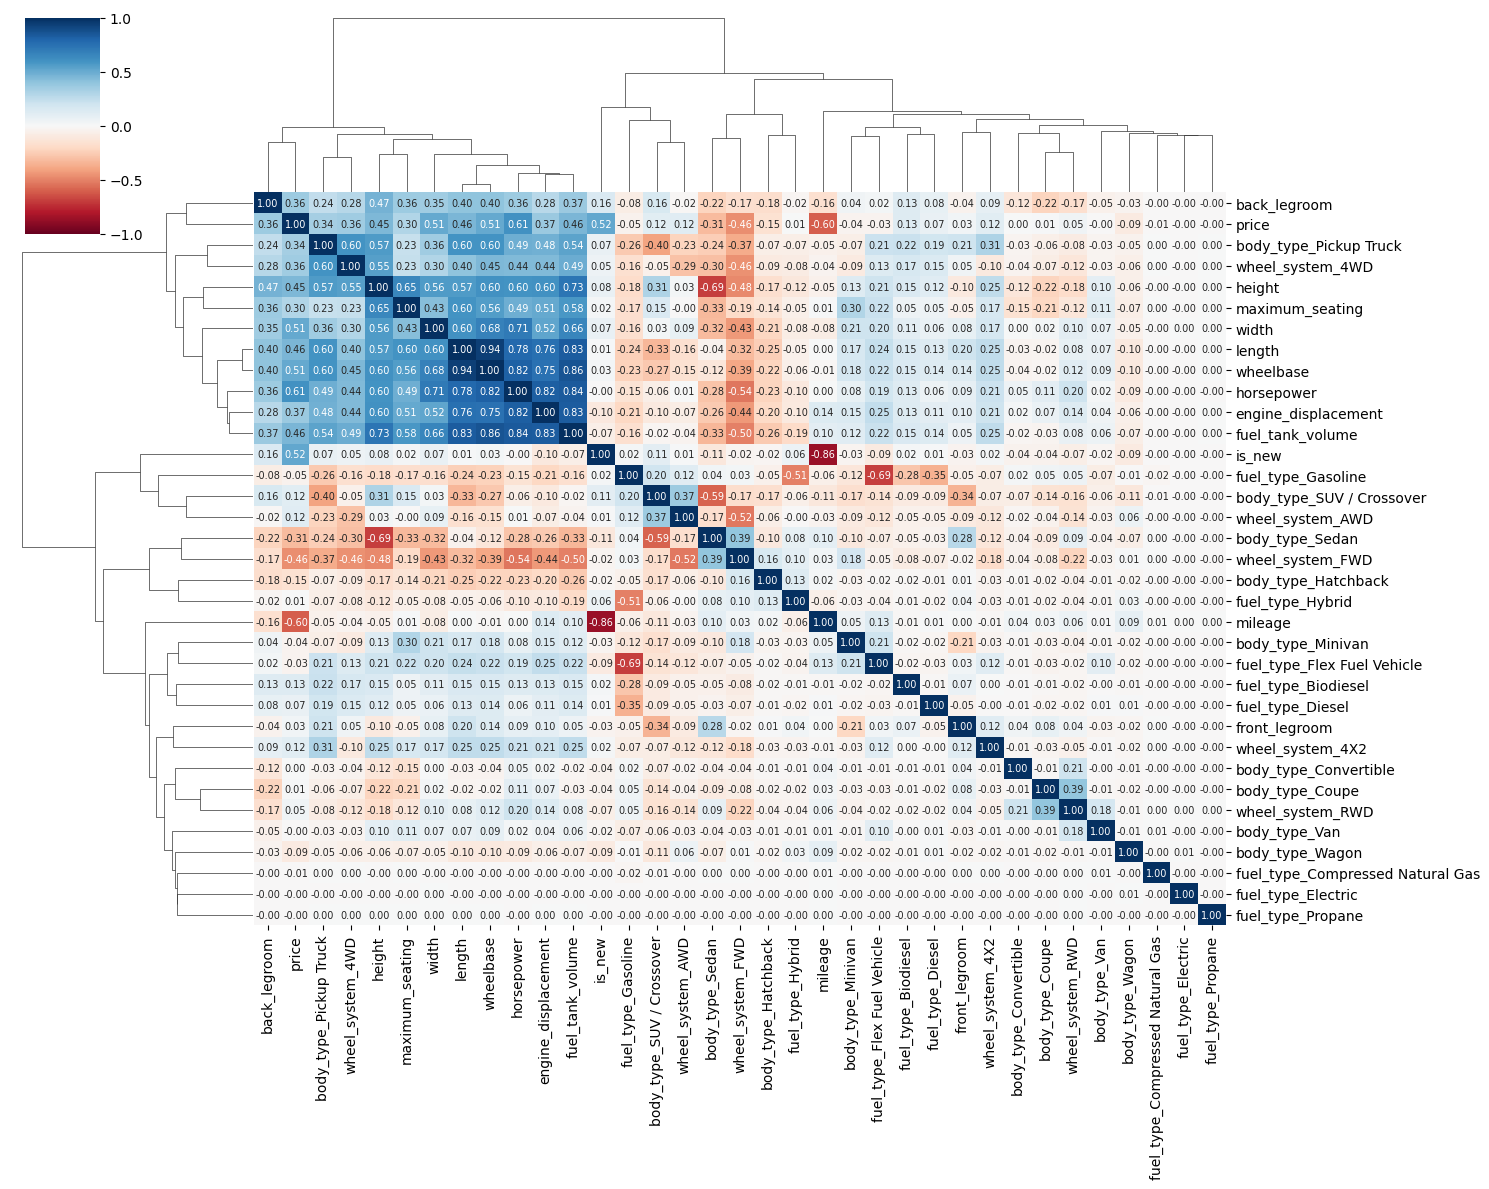

In [12]:
plot_clustermap(df.drop(columns=DATE_NAME))

There is evidence here of multicollinearity which should ideally be addressed but the main purpose here is to test out Ray Tune for hyperparameter optimisation so we will proceed without addressing this.

## Model fitting

Now fit and tune the models specified in `MODELS_CONFIG`.

In [13]:
from sklearn.metrics import r2_score

from tune_configs import MODELS_CONFIG
from cv import construct_ts_folds, tune_all_models

In [14]:
N_SPLITS = 10
GAP = 10
MAX_TRAIN_SIZE = None
SCORE_FUNC = r2_score

In [15]:
dts = df[DATE_NAME].unique()

folds = construct_ts_folds(
    dts=dts, 
    n_splits=N_SPLITS,
    gap=GAP,
    max_train_size=MAX_TRAIN_SIZE,
)

In [16]:
best_results_dict = tune_all_models(
    df, 
    folds, 
    models_config=MODELS_CONFIG,
    target_name=TARGET_NAME,
    feature_names=FEATURE_NAMES,
    date_name=DATE_NAME,
    score_func=SCORE_FUNC,
)

(report_cv_score pid=48740) [LightGBM] [Warning] lambda_l1 is set=0.0009371690004310936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009371690004310936
(report_cv_score pid=48740) [LightGBM] [Warning] feature_fraction is set=0.9056682253487249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9056682253487249
(report_cv_score pid=48740) [LightGBM] [Warning] num_threads is set=16, n_jobs=-1 will be ignored. Current value: num_threads=16
(report_cv_score pid=48740) [LightGBM] [Warning] lambda_l2 is set=0.5072198400722647, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5072198400722647
(report_cv_score pid=48740) [LightGBM] [Warning] lambda_l1 is set=0.0009371690004310936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009371690004310936
(report_cv_score pid=48740) [LightGBM] [Warning] feature_fraction is set=0.9056682253487249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9056682253487249
(report_cv_

2023-01-15 13:43:12,874	INFO tune.py:762 -- Total run time: 725.98 seconds (725.81 seconds for the tuning loop).


In [17]:
best_results_dict.keys()

dict_keys(['Ridge', 'Lasso', 'RF', 'XGB', 'LGBM'])

In [19]:
for k, v in best_results_dict.items():
    print(k, v.metrics["score"])

Ridge 0.5629682834289591
Lasso 0.5614646948925615
RF 0.49884976110475454
XGB 0.6929692018673725
LGBM 0.6820516161007976


We see that gradient boosting works particularly well on this dataset.